In [371]:
import pandas as pd
from IPython.display import clear_output

In [608]:
import random
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
import matplotlib.pyplot as plt

class DifferencingDecisionModel:
    
    def __init__(self):
        pass
        
    def convert_p_to_z(self, d_prime, k2, k1=None):
        if k1 is None:
            k1 = k2
        
        p_false = st.norm.cdf(-k1) + st.norm.cdf(-k2)
        p_hit = st.norm.cdf(-d_prime - k1) + st.norm.cdf(d_prime - k2)

        #print(st.norm.cdf(-d_prime - k1))
        #print(st.norm.cdf(d_prime - k2))
        #print(f"P(h): {p_k1_hit}")
        #print(f"P(f): {p_k1_false}")
        
        return st.norm.ppf(p_false), st.norm.ppf(p_hit)
    
    def sample_k1_k2_values(self, k_range, d_prime, num_points):
        
        zf_vals = []
        zh_vals = []
        
        k_range = [n for n in np.linspace(k_range['k_min'], k_range['k_max'], k_range['k_num'])]
        for _ in range(num_points):
            k1 = random.choice(k_range)
            k2 = random.choice(k_range)
            z_f, z_h = self.convert_p_to_z(d_prime, k2, k1)
            
            zf_vals.append(z_f)
            zh_vals.append(z_h)
            
        return zf_vals, zh_vals
    
    def sample_k_values(self, k_range, d_prime, num_points):
        
        zf_vals = []
        zh_vals = []
        
        k_range = [n for n in np.linspace(k_range['k_min'], k_range['k_max'], k_range['k_num'])]
        for _ in range(num_points):
            k = random.choice(k_range)
            z_f, z_h = self.convert_p_to_z(d_prime, k, k)
            
            zf_vals.append(z_f)
            zh_vals.append(z_h)
            
        return zf_vals, zh_vals
        
    def generate_model(self, k_min, k_max, k_num, d_prime, k1=None):
        z_f_values = []
        z_h_values = []
        
        for k2 in np.linspace(k_min, k_max, k_num):
            if k1 is None:
                k1 = k
            z_f, z_h = self.convert_p_to_z(d_prime, k2, k1)
            z_f_values.append(z_f)
            z_h_values.append(z_h)
        
        return linregress(z_f_values, z_h_values)
        
    def fit_df1_model(self, k_range, dp_range, zf_vals, zh_vals):
        
        best_model = None
        lowest_mse = np.inf
        best_dp = 0
        
        for d_p in np.linspace(dp_range['dp_min'], dp_range['dp_max'], dp_range['dp_num']):
            print(f"Checking d'={d_p}.")
            model = self.generate_model(k_range['k_min'], k_range['k_max'], k_range['k_num'], d_p)
            
            #check how well the model fits the data
            y_pred = [model.intercept + model.slope * n for n in zf_vals]
            mse = np.mean([(y_a - y_p)**2 for y_a, y_p in zip(zh_vals, y_pred)])
            
            if mse < lowest_mse:
                lowest_mse = mse
                best_model = model
                best_dp = d_p
                
            clear_output()
                
        return best_model, best_dp, lowest_mse
    
    def fit_df2_model(self, k_range, dp_range, zf_vals, zh_vals):
        
        best_model = None
        lowest_mse = np.inf
        best_dp = 0
        
        for dp in np.linspace(dp_range['dp_min'], dp_range['dp_max'], dp_range['dp_num']):
            print(f"Checking d'={dp}.")
            
            for k1 in np.linspace(k_range['k_min'], k_range['k_max'], k_range['k_num']):
                model = self.generate_model(k_range['k_min'], k_range['k_max'], k_range['k_num'], dp, k1=k1, return_plot=False)

                #check how well the model fits the data
                y_pred = [model.intercept + model.slope * n for n in zf_vals]
                mse = np.mean([(y_a - y_p)**2 for y_a, y_p in zip(zh_vals, y_pred)])

                if mse < lowest_mse:
                    lowest_mse = mse
                    best_model = model
                    best_dp = dp

            clear_output()
                
        return best_model, best_dp, lowest_mse
        

In [609]:
diff_model = DifferencingDecisionModel()

# DF2 k-Value Grid Sampling

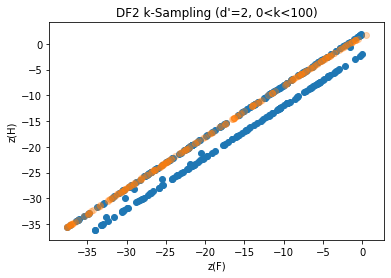

In [611]:
k_range = {'k_min': 0, 'k_max': 100, 'k_num': 1000}
zf_vals, zh_vals = diff_model.sample_k1_k2_values(k_range, 2, 500)
zf_vals_k, zh_vals_k = diff_model.sample_k_values(k_range, 2, 500)

plt.scatter(zf_vals, zh_vals)
plt.scatter(zf_vals_k, zh_vals_k, alpha=0.3)
plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.title('DF2 k-Sampling (d\'=2, 0<k<100)')
plt.savefig('df2_sampling_largek.png')

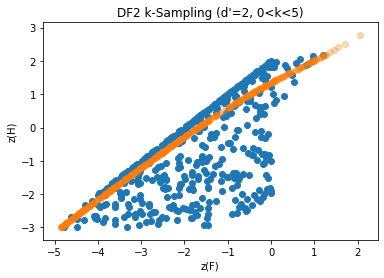

In [615]:
k_range = {'k_min': 0, 'k_max': 5, 'k_num': 1000}
zf_vals, zh_vals = diff_model.sample_k1_k2_values(k_range, 2, 500)
zf_vals_k, zh_vals_k = diff_model.sample_k_values(k_range, 2, 500)

plt.scatter(zf_vals, zh_vals)
plt.scatter(zf_vals_k, zh_vals_k, alpha=0.3)
plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.title('DF2 k-Sampling (d\'=2, 0<k<5)')
plt.savefig('df2_sampling_smallk.png')

# Testing DF Model Against Subject LoBF

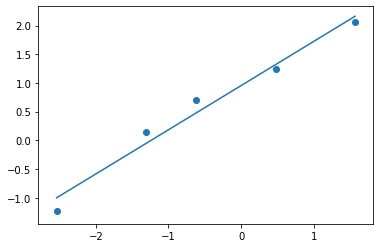

In [627]:
deg8_data = pd.read_csv('data_8degree.csv', index_col=0)
sub_data = deg8_data.iloc[3]
zf_vals = sub_data.filter(like='ZF').tolist()
zh_vals = sub_data.filter(like='ZH').tolist()

model = linregress(zf_vals, zh_vals)
y_pred = [model.intercept + model.slope * n for n in zf_vals]
plt.plot(zf_vals, y_pred)
plt.scatter(zf_vals, zh_vals)

Text(0.5, 1.0, 'DF1 Model Fit')

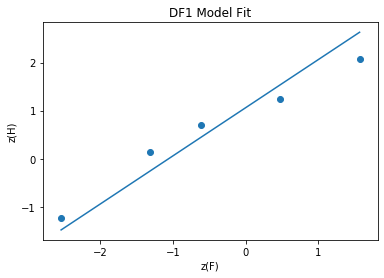

In [641]:
k_range = {'k_min': 0.5, 'k_max': 5, 'k_num': 100}
dp_range = {'dp_min': 0.5, 'dp_max': 2, 'dp_num': 100}

model, dp, mse = diff_model.fit_df1_model(k_range, dp_range, zf_vals, zh_vals)

y_pred = [model.intercept + model.slope * n for n in zf_vals]
plt.plot(zf_vals, y_pred)
plt.scatter(zf_vals, zh_vals)
plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.title('DF1 Model Fit')

Text(0.5, 1.0, 'DF2 Model Fit')

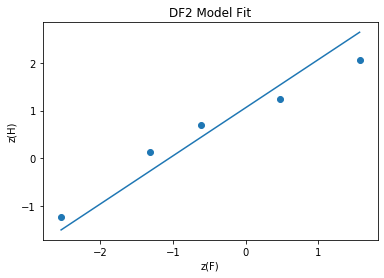

In [642]:
k_range = {'k_min': 0, 'k_max': 5, 'k_num': 50}
dp_range = {'dp_min': 0.5, 'dp_max': 2, 'dp_num': 75}

model, dp, mse = diff_model.fit_df2_model(k_range, dp_range, zf_vals, zh_vals)

y_pred = [model.intercept + model.slope * n for n in zf_vals]
plt.plot(zf_vals, y_pred)
plt.scatter(zf_vals, zh_vals)
plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.title('DF2 Model Fit')